In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

## 1.1 Compute ROC & AUC for combined test sets. n=10, r=4

In [2]:
def convert_txt_to_array(filepath):
    preds = []
    txt = open(filepath, 'r')
    for line in txt:
        preds.append(line)
    preds = np.array(preds).astype('float32')
    return preds    

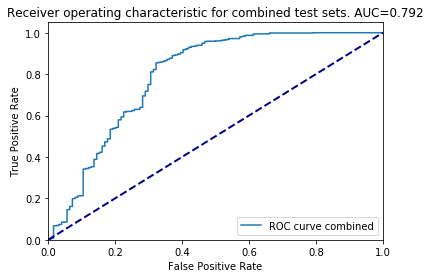

In [3]:
## Load in prediction files
english_preds = convert_txt_to_array('english_testpred_r4.txt')
tagalan_preds = convert_txt_to_array('tagalog_testpred_r4.txt')
combined_preds = convert_txt_to_array('combined_testpred_r4.txt')
preds = [english_preds, tagalan_preds, combined_preds]
names = ['english', 'tagalan', 'combined']

## determine class labels
n_english, n_tagalan, n_combined = english_preds.shape[0], tagalan_preds.shape[0], combined_preds.shape[0]
english_labels = np.zeros(n_english)
tagalan_labels = np.ones(n_tagalan)
combined_labels = np.ones(n_combined)
combined_labels[:n_english] = 0.
labels = [english_labels, tagalan_labels, combined_labels]

## fit roc curve on combined labels
plt.figure()   
fpr, tpr, _ = roc_curve(y_true=combined_labels, y_score=combined_preds)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve '+names[2])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic for combined test sets. AUC={np.round(auc_score,3)}')
plt.legend(loc="lower right")
plt.savefig('figures/1a_roc_curve.png')
plt.show()



## 1.2 : varying the value of r

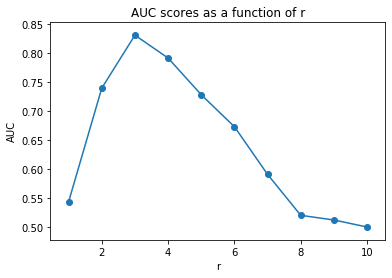

In [4]:
r_values = np.arange(1,11) 
auc_scores = np.zeros(len(r_values))
for i,r in enumerate(r_values):
    filepath = f'r_values/r{r}_preds.txt'
    preds = convert_txt_to_array(filepath)
    fpr, tpr, _ = roc_curve(y_true=combined_labels, y_score=preds)
    auc_scores[i] = auc(fpr, tpr)
    
## Plot auc scores as a function of r
plt.figure()
plt.plot(r_values, auc_scores)
plt.scatter(r_values, auc_scores)
plt.xlabel('r')
plt.ylabel('AUC')
plt.title('AUC scores as a function of r')
plt.savefig('figures/1b_auc_scores.png')
plt.show()    

## 1.3 Diffferent languages

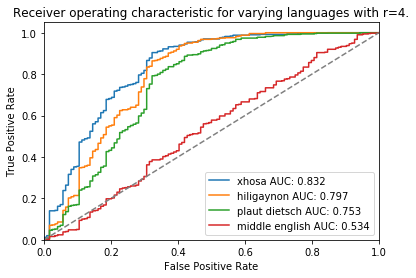

In [5]:
## load in predictions
hiligaynon = 'lang/english_hiligaynon_r4_preds.txt'
middle_english = 'lang/english_middle-english_r4_preds.txt'
plautdietsch = 'lang/english_plautdietsch_r4_preds.txt'
xhosa = 'lang/english_xhosa_r4_preds.txt'
paths = [xhosa, hiligaynon, plautdietsch, middle_english]
names = [ 'xhosa', 'hiligaynon'  , 'plaut dietsch', 'middle english']

## iterate over languages
FPR, TPR, AUC = [], [], np.zeros(len(paths))
for i, path in enumerate(paths):
    pred = convert_txt_to_array(path)
    labels = np.ones(len(pred))
    labels[:n_english] = 0.

    # save fpr, tpr
    fpr, tpr, _ = roc_curve(y_true=labels, y_score=pred)
    AUC[i] = auc(fpr, tpr)
    FPR.append(fpr)
    TPR.append(tpr)
    
    
## plot ROC curves
plt.figure()  
for i, (fpr, tpr) in enumerate(zip(FPR,TPR)):
    plt.plot(fpr, tpr, label=f'{names[i]} AUC: {np.round(AUC[i],3)}')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic for varying languages with r=4.')
plt.legend(loc="lower right")
plt.savefig('figures/1c1_roc_curves.png')
plt.show()

## Plot AUC values as bar plot


## Question 2: dataset 1 - snd-cert folder

In [67]:
import os

## load in alphabet of cert
for line in open('syscalls/snd-cert/snd-cert.alpha', 'r'):
    sndcert_alphabet = line

## fix data of training set
sndcert_train = []
k = 7 # string length
for line in open('syscalls/snd-cert/snd-cert.train', 'r'):
    # iterate over all lines
    string = line
    while len(string) >= k:
        # add bits of length n to array
        sndcert_train.append(string[:k])
        string = string[1:]
sndcert_train = np.array(sndcert_train)
            
# save new training format
with open('syscalls/snd-cert/snd-cert.trainfixed', 'w') as output_file:
    for i in range(len(sndcert_train)):
        output_file.write(sndcert_train[i]+'\n')
    
print('done with writing training file')

## fix data of test sets and labels
test_sets = ['snd-cert/snd-cert.1.test', 'snd-unm/snd-cert.2.test', 'snd-cert/snd-cert.3.test']
labels = ['snd-cert/snd-cert.1.labels', 'snd-unm/snd-cert.2.labels', 'snd-cert/snd-cert.3.labels']
test_ids = []
for i, (test_set, label) in enumerate(zip(test_sets, labels)):
    cert_test= []
    cert_labels = []
    # Read in labels of each unchunked line
    labels = []
    for line in open('syscalls/'+label, 'r'):
        labels.append(line)
    labels = np.array(np.float32(labels))
    print(labels)
    
    # read in test data, save chunked strings
    for j, line in enumerate(open('syscalls/'+test_set,'r')):
        string = line
        cert_ids = []
        while len(string)>=k:
            cert_test.append(string[:k])
            string = string[1:]
            cert_labels.append(labels[j])
            cert_ids.append(j)
    cert_labels = np.array(cert_labels)        
    cert_test = np.array(cert_test)        
    assert cert_labels.shape == cert_test.shape
    ## write results back to txt files
    with open('syscalls/'+test_set+'fixed', 'w') as output_file:
        for i in range(len(unm_test)):
            output_file.write(cert_test[i]+'\n')
    with open('syscalls/'+label+'fixed', 'w') as output_file:
        for i in range(len(cert_test)):
            output_file.write(str(cert_labels[i])+'\n')  

done with writing training file
[0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 1. 1. 1.]


FileNotFoundError: [Errno 2] No such file or directory: 'syscalls/snd-unm/snd-cert.2.labels'

(45608,) (45608,)
(430522,) (430522,)
(868691,) (868691,)


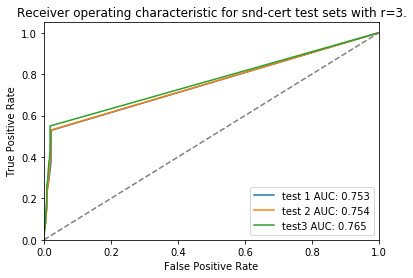

ValueError: x and y must have same first dimension, but have shapes (7,) and (3,)

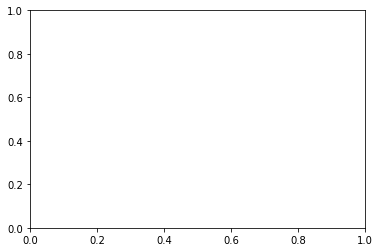

In [19]:
## Get ROC for snd-cert test sets
test_sets = ['snd-cert/snd-cert.1.testfixed', 'snd-cert/snd-cert.2.testfixed', 'snd-cert/snd-cert.3.testfixed']
labels = ['snd-cert/snd-cert.1.labelsfixed', 'snd-cert/snd-cert.2.labelsfixed', 'snd-cert/snd-cert.3.labelsfixed']
r = 3
FPR, TPR, AUC = [], [], np.zeros(len(test_sets))

for i, (test_set, label) in enumerate(zip(test_sets, labels)):
    # write predictions in txt file
    store_path = 'syscalls/snd-cert/test'+f'{i+1}preds.txt'
    os.system('java -jar negsel2.jar -self syscalls/snd-cert/snd-cert.trainfixed -n 7 -r '+str(r)+' -c -l < syscalls/'+test_set +' > '+store_path)

    # load in labels
    labels = []
    for line in open('syscalls/'+label, 'r'):
        labels.append(np.float32(line))
    labels = np.array(labels) 
    
    ## load in predictions
    preds, new_labels = [], []
    for j, line in enumerate(open(store_path, 'r')):
        line_preds = np.array(line.split()).astype(np.float)
        preds.extend(line_preds)
        
        for _ in line_preds:
            new_labels.append(labels[j])
        
    preds = np.array(preds)
    new_labels = np.array(new_labels)
    assert preds.shape==new_labels.shape
    print(preds.shape, new_labels.shape)
    
    ## save fpr, tpr
    fpr, tpr, _ = roc_curve(y_true=new_labels, y_score=preds)
    AUC[i] = auc(fpr, tpr)
    FPR.append(fpr)
    TPR.append(tpr)
    
## plot ROC curves
names = np.array(['test 1', 'test 2', 'test3'])
plt.figure()  
for i, (fpr, tpr) in enumerate(zip(FPR,TPR)):
    plt.plot(fpr, tpr, label=f'{names[i]} AUC: {np.round(AUC[i],3)}')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver operating characteristic for snd-cert test sets with r=3.')
plt.legend(loc="lower right")
plt.savefig('figures/2_snd-cert_roc_curves.png')
plt.show()

(45608,) (45608,)
(45608,) (45608,)
(430522,) (430522,)
(430522,) (430522,)
(868691,) (868691,)
(868691,) (868691,)


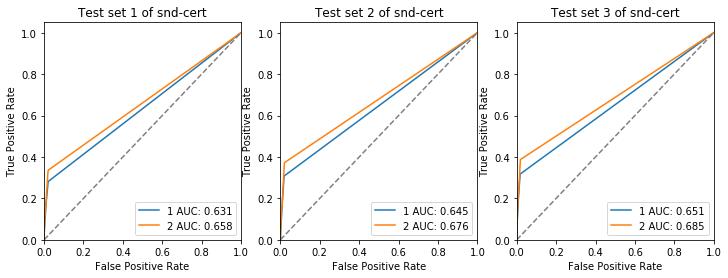

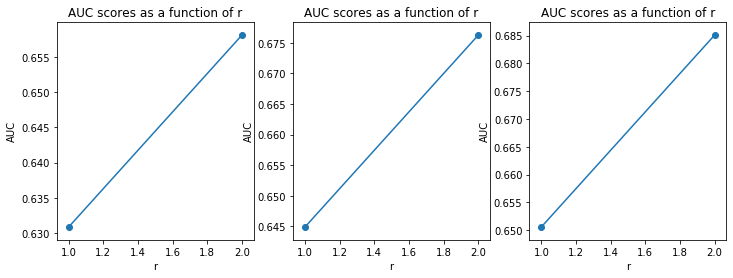

In [53]:
## Run all cert test sets, for all r values
test_sets = ['snd-cert/snd-cert.1.testfixed', 'snd-cert/snd-cert.2.testfixed', 'snd-cert/snd-cert.3.testfixed']
labels = ['snd-cert/snd-cert.1.labelsfixed', 'snd-cert/snd-cert.2.labelsfixed', 'snd-cert/snd-cert.3.labelsfixed']
r_values = np.arange(1,3)

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax = ax.ravel()
AUC_scores = []

for n, (test_set, label) in enumerate(zip(test_sets, labels)):
    FPR, TPR, AUC = [], [], np.zeros((len(r_values)))

    for i, r in enumerate(r_values):
        # write predictions in txt file
        store_path = 'syscalls/snd-cert/test'+f'1preds_r{str(r)}.txt'
        os.system('java -jar negsel2.jar -self syscalls/snd-cert/snd-cert.trainfixed -n 7 -r '+str(r)+' -c -l < syscalls/'+test_set +' > '+store_path)

        # load in labels
        labels = []
        for line in open('syscalls/'+label, 'r'):
            labels.append(np.float32(line))
        labels = np.array(labels) 

        ## load in predictions
        preds, new_labels = [], []
        for j, line in enumerate(open(store_path, 'r')):
            line_preds = np.array(line.split()).astype(np.float)
            preds.extend(line_preds)

            for _ in line_preds:
                new_labels.append(labels[j])

        preds = np.array(preds)
        new_labels = np.array(new_labels)
        assert preds.shape==new_labels.shape
        print(preds.shape, new_labels.shape)

        ## save fpr, tpr
        fpr, tpr, _ = roc_curve(y_true=new_labels, y_score=preds)
        AUC[i] = auc(fpr, tpr)
        FPR.append(fpr)
        TPR.append(tpr)
    
    ## plot ROC curves
    for i, (fpr, tpr) in enumerate(zip(FPR,TPR)):
        ax[n].plot(fpr, tpr, label=f'{r_values[i]} AUC: {np.round(AUC[i],3)}')
    ax[n].plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
    ax[n].set_xlim([0.0, 1.0])
    ax[n].set_ylim([0.0, 1.05])
    ax[n].set_xlabel('False Positive Rate')
    ax[n].set_ylabel('True Positive Rate')
    ax[n].set_title(f'Test set {n+1} of snd-cert')
    ax[n].legend(loc="lower right")
    
    AUC_scores.append(AUC)
    
    
plt.savefig(f'figures/2_snd-cert_r_values.png')
plt.show()

# Plot r values as scatter plot

fig2, ax2 = plt.subplots(1,3,figsize=(12,4))
ax2 = ax2.ravel()
for n, AUC in enumerate(AUC_scores):
    ax2[n].plot(r_values, AUC)
    ax2[n].scatter(r_values, AUC)
    ax2[n].set_xlabel('r')
    ax2[n].set_ylabel('AUC')
    ax2[n].set_title('AUC scores as a function of r')
plt.savefig('figures/1b_auc_scores.png')
plt.show()    

## dataset 2 - snd-unm 

In [62]:
## load in alphabet of unm
for line in open('syscalls/snd-unm/snd-unm.alpha', 'r'):
    unm_alphabet = line

## fix data of training set
unm_train = []
k = 7 # string length
for line in open('syscalls/snd-unm/snd-unm.train', 'r'):
    # iterate over all lines
    string = line
    if len(string) >= k:
        # add bits of length n to array
        unm_train.append(string[:k])
        string = string[1:]
unm_train = np.array(unm_train)
            
# save new training format
with open('syscalls/snd-unm/snd-unm.trainfixed', 'w') as output_file:
    for i in range(len(sndcert_train)):
        output_file.write(sndcert_train[i]+'\n')
    
print('done with writing training file')

## fix data of test sets and labels
test_sets = ['snd-unm/snd-unm.1.test', 'snd-unm/snd-unm.2.test', 'snd-unm/snd-unm.3.test']
labels = ['snd-unm/snd-unm.1.labels', 'snd-unm/snd-unm.2.labels', 'snd-unm/snd-unm.3.labels']
for i, (test_set, label) in enumerate(zip(test_sets, labels)):
    unm_test= []
    unm_labels = []
    # Read in labels of each unchunked line
    labels = []
    for line in open('syscalls/'+label, 'r'):
        labels.append(line)
    labels = np.array(np.float32(labels))
    print(labels)
    
    # read in test data, save chunked strings
    for j, line in enumerate(open('syscalls/'+test_set,'r')):
        string = line
        if len(string)>=k:
            unm_test.append(string[:k])
            string = string[1:]
            unm_labels.append(labels[j])
    unm_labels = np.array(unm_labels)        
    unm_test = np.array(unm_test)        
    assert unm_labels.shape == unm_test.shape
    ## write results back to txt files
    with open('syscalls/'+test_set+'fixed', 'w') as output_file:
        for i in range(len(unm_test)):
            output_file.write(unm_test[i]+'\n')
    with open('syscalls/'+label+'fixed', 'w') as output_file:
        for i in range(len(unm_test)):
            output_file.write(str(unm_labels[i])+'\n')        

done with writing training file
[1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 1. 0. 0.]
[0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0

(100,) (100,)
(550,) (550,)
(1050,) (1050,)


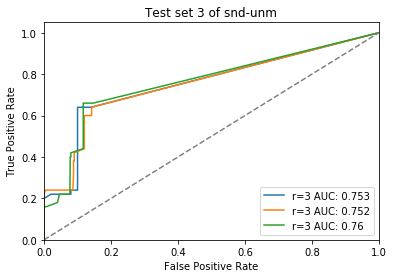

In [64]:
## Get ROC for snd-cert test sets
test_sets = ['snd-unm/snd-unm.1.testfixed', 'snd-unm/snd-unm.2.testfixed', 'snd-unm/snd-unm.3.testfixed']
labels = ['snd-unm/snd-unm.1.labelsfixed', 'snd-unm/snd-unm.2.labelsfixed', 'snd-unm/snd-unm.3.labelsfixed']
r = 3

FPR, TPR, AUC = [], [], np.zeros(len(test_sets))

for i, (test_set, label) in enumerate(zip(test_sets, labels)):
    # write predictions in txt file
    store_path = 'syscalls/snd-unm/test'+f'{i+1}preds.txt'
    os.system('java -jar negsel2.jar -self syscalls/snd-unm/snd-unm.trainfixed -n 7 -r '+str(r)+' -c -l < syscalls/'+test_set +' > '+store_path)

    # load in labels
    labels = []
    for line in open('syscalls/'+label, 'r'):
        labels.append(np.float32(line))
    labels = np.array(labels) 

    ## load in predictions
    preds, new_labels = [], []
    for j, line in enumerate(open(store_path, 'r')):
        line_preds = np.array(line).astype(np.float)
        preds.append(line_preds)
        
        
    preds = np.array(preds)
    print(preds.shape, labels.shape)
    assert preds.shape==labels.shape
    ## save fpr, tpr
    fpr, tpr, _ = roc_curve(y_true=labels, y_score=preds)
    AUC[i] = auc(fpr, tpr)
    FPR.append(fpr)
    TPR.append(tpr)
    
    ## plot ROC curves
plt.figure()
for i, (fpr, tpr) in enumerate(zip(FPR,TPR)):
    plt.plot(fpr, tpr, label=f'r={r} AUC: {np.round(AUC[i],3)}')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Test set {n+1} of snd-unm')
plt.legend(loc="lower right")
plt.savefig('figures/2_snd-unm_roc_curves.png')
plt.show()


(45153,) (45153,)
(45153,) (45153,)
(45153,) (45153,)
(45153,) (45153,)
(45153,) (45153,)
(45153,) (45153,)
(45153,) (45153,)
(450952,) (450952,)
(450952,) (450952,)
(450952,) (450952,)
(450952,) (450952,)
(450952,) (450952,)
(450952,) (450952,)
(450952,) (450952,)
(880844,) (880844,)
(880844,) (880844,)
(880844,) (880844,)
(880844,) (880844,)
(880844,) (880844,)
(880844,) (880844,)
(880844,) (880844,)


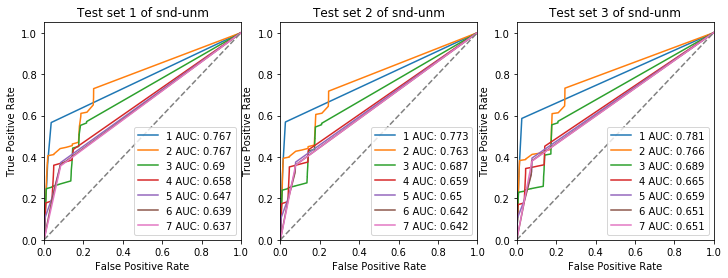

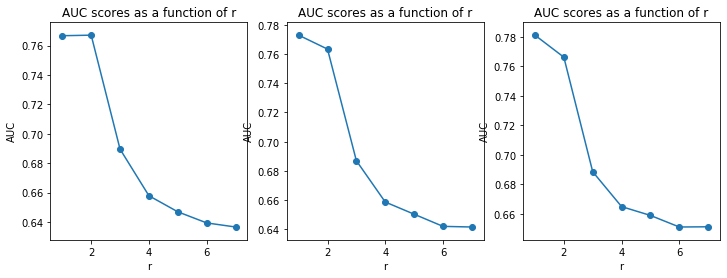

In [65]:
## Run all cert test sets, for all r values
test_sets = ['snd-unm/snd-unm.1.test', 'snd-unm/snd-unm.2.test', 'snd-unm/snd-unm.3.test']
labels = ['snd-unm/snd-unm.1.labels', 'snd-unm/snd-unm.2.labels', 'snd-unm/snd-unm.3.labels']
r_values = np.arange(1,8)
AUC_scores = []
fig, ax = plt.subplots(1,3,figsize=(12,4))
ax = ax.ravel()

for n, (test_set, label) in enumerate(zip(test_sets, labels)):
    FPR, TPR, AUC = [], [], np.zeros((len(r_values)))

    for i, r in enumerate(r_values):
        # write predictions in txt file
        store_path = 'syscalls/snd-unm/test'+f'1preds_r{str(r)}.txt'
        os.system('java -jar negsel2.jar -self syscalls/snd-unm/snd-unm.trainfixed -n 7 -r '+str(r)+' -c -l < syscalls/'+test_set +' > '+store_path)

        # load in labels
        labels = []
        for line in open('syscalls/'+label, 'r'):
            labels.append(np.float32(line))
        labels = np.array(labels) 

        ## load in predictions
        preds, new_labels = [], []
        for j, line in enumerate(open(store_path, 'r')):
            line_preds = np.array(line.split()).astype(np.float)
            preds.extend(line_preds)

            for _ in line_preds:
                new_labels.append(labels[j])

        preds = np.array(preds)
        new_labels = np.array(new_labels)
        assert preds.shape==new_labels.shape
        print(preds.shape, new_labels.shape)

        ## save fpr, tpr
        fpr, tpr, _ = roc_curve(y_true=new_labels, y_score=preds)
        AUC[i] = auc(fpr, tpr)
        FPR.append(fpr)
        TPR.append(tpr)
    
    ## plot ROC curves
    for i, (fpr, tpr) in enumerate(zip(FPR,TPR)):
        ax[n].plot(fpr, tpr, label=f'{r_values[i]} AUC: {np.round(AUC[i],3)}')
    ax[n].plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
    ax[n].set_xlim([0.0, 1.0])
    ax[n].set_ylim([0.0, 1.05])
    ax[n].set_xlabel('False Positive Rate')
    ax[n].set_ylabel('True Positive Rate')
    ax[n].set_title(f'Test set {n+1} of snd-unm')
    ax[n].legend(loc="lower right")
    
    AUC_scores.append(AUC)
    
    
plt.savefig(f'figures/2_snd-unm_r_values.png')
plt.show()

fig2, ax2 = plt.subplots(1,3,figsize=(12,4))
ax2 = ax2.ravel()
for n, AUC in enumerate(AUC_scores):
    ax2[n].plot(r_values, AUC)
    ax2[n].scatter(r_values, AUC)
    ax2[n].set_xlabel('r')
    ax2[n].set_ylabel('AUC')
    ax2[n].set_title('AUC scores as a function of r')
plt.savefig('figures/2_snd-unm_auc_scores.png')
plt.show()    
